In [1]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('../training_data/yeast_3-mers.csv')
df.head()

,3mer,coding
0,CCA,0
1,CAC,0
2,ACA,0
3,CAC,0
4,ACC,0


In [13]:
# Convert observations to numeric
unique_3mers = df['3mer'].unique()
mer_to_idx = {mer: i for i, mer in enumerate(unique_3mers)}
X = np.array([mer_to_idx[mer] for mer in df['3mer']]).reshape(-1, 1)

# Get true states
y = df['coding'].values

print(f"Total 3-mers: {len(X)}")
print(f"Class distribution: Non-coding={np.sum(y==0)}, Coding={np.sum(y==1)}")
print(unique_3mers)

Total 3-mers: 12157103
Class distribution: Non-coding=3403065, Coding=8754038
['CCA' 'CAC' 'ACA' 'ACC' 'CCC' 'CAT' 'ATC' 'TCC' 'CCT' 'CTA' 'TAA' 'AAC'
 'ACT' 'TAC' 'CAG' 'AGC' 'GCC' 'AAT' 'TCT' 'CTG' 'TGG' 'GGC' 'CAA' 'TGT'
 'GTC' 'CTC' 'TCA' 'CTT' 'TTA' 'ATT' 'TGC' 'TCG' 'CGT' 'GTT' 'TTC' 'ATA'
 'CCG' 'CGA' 'GAA' 'TAT' 'ATG' 'TGA' 'GAC' 'TTG' 'AAA' 'ACG' 'CGC' 'GCT'
 'GAT' 'GTA' 'GTG' 'TTT' 'GCA' 'CGG' 'GGA' 'AGT' 'AGA' 'GCG' 'GGT' 'TAG'
 'AAG' 'AGG' 'GAG' 'GGG']


In [4]:
# Split into train and test sets (80/20)
split_idx = int(0.8 * len(X))

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

baseline_accuracy = max(np.mean(y_test == 0), np.mean(y_test == 1))
print(f"Baseline accuracy (assume entire sequence is coding): {baseline_accuracy}")
train_baseline_accuracy = max(np.mean(y_train == 0), np.mean(y_train == 1))
print(f"Baseline accuracy (assume entire sequence is coding): {train_baseline_accuracy}")

Train size: 9725682, Test size: 2431421
Baseline accuracy (assume entire sequence is coding): 0.7029551854656186
Baseline accuracy (assume entire sequence is coding): 0.724356194249411


In [5]:
# Class majority map baseline
from collections import Counter, defaultdict

train_mers = df["3mer"].iloc[:split_idx]
test_mers = df["3mer"].iloc[split_idx:]

# majority vote for each k-mer observed in training
mer_counts = defaultdict(Counter)
for mer, label in zip(train_mers, y_train):
    mer_counts[mer][label] += 1
mer_majority = {mer: cnt.most_common(1)[0][0] for mer, cnt in mer_counts.items()}

global_majority = int(y_train.mean() >= 0.5)

train_preds = np.array([mer_majority[mer] for mer in train_mers])
test_preds = np.array([mer_majority.get(mer, global_majority) for mer in test_mers])

print(f"Train accuracy (per-3-mer majority): {accuracy_score(y_train, train_preds):.4f}")
print(f"Test accuracy  (per-3-mer majority): {accuracy_score(y_test, test_preds):.4f}")
print(f"Test accuracy  (single global class): {max(np.mean(y_test == 0), np.mean(y_test == 1)):.4f}")


Train accuracy (per-3-mer majority): 0.7244
Test accuracy  (per-3-mer majority): 0.7030
Test accuracy  (single global class): 0.7030


In [7]:
# Estimate HMM parameters using supervised learning
n_states = 2
n_features = len(unique_3mers)

# Calculate initial state probabilities
initial_probs = np.zeros(n_states)
for state in range(n_states):
    initial_probs[state] = np.mean(y_train == state)
initial_probs = initial_probs / initial_probs.sum()
print(f'pi: {initial_probs}')

# Calculate transition probabilities from training labels
transition_matrix = np.zeros((n_states, n_states))
for i in range(len(y_train) - 1):
    current_state = y_train[i]
    next_state = y_train[i + 1]
    transition_matrix[current_state, next_state] += 1

for state in range(n_states):
    row_sum = transition_matrix[state].sum()
    if row_sum > 0:
        transition_matrix[state] = transition_matrix[state] / row_sum
    else:
        transition_matrix[state] = 1.0 / n_states

print(f'a: {transition_matrix}')

# Calculate emission probabilities from training labels
emission_matrix = np.zeros((n_states, n_features))
for i in range(len(y_train)):
    state = y_train[i]
    observation = X_train[i, 0]
    emission_matrix[state, observation] += 1

for state in range(n_states):
    #to prevent underflow
    emission_matrix[state] += 1e-6
    emission_matrix[state] = emission_matrix[state] / emission_matrix[state].sum()

print(f'b: {emission_matrix}')

pi: [0.27564381 0.72435619]
a: [[9.98144973e-01 1.85502736e-03]
 [7.05904931e-04 9.99294095e-01]]
b: [[0.01026923 0.01035726 0.01829549 0.00918151 0.00630478 0.01743531
  0.01490213 0.01043411 0.01057921 0.01408895 0.02786494 0.01726447
  0.01556051 0.01637631 0.01009876 0.01057697 0.00658865 0.03150561
  0.0189811  0.01011816 0.01024237 0.00658305 0.01983607 0.01840069
  0.00761221 0.01013382 0.01760429 0.02109389 0.02778884 0.03146644
  0.01162255 0.00825642 0.00869695 0.01748828 0.02254083 0.03411936
  0.00531851 0.00816503 0.02260947 0.0339571  0.01731184 0.01754274
  0.00762116 0.01984315 0.05045762 0.00860855 0.0061317  0.01047029
  0.01488684 0.01640652 0.0103692  0.05025805 0.01171953 0.00532784
  0.01043784 0.015634   0.0191001  0.0061399  0.00917591 0.0141934
  0.02138745 0.01058816 0.01006407 0.0060045 ]
 [0.01688011 0.01086637 0.01682277 0.01260707 0.00697445 0.01883899
  0.01876503 0.01360425 0.01171507 0.01229975 0.01963971 0.01838376
  0.0149113  0.01335854 0.01358906 0.

In [19]:
emission_matrix_diff = emission_matrix[0] - emission_matrix[1]
# Create a labeled version of emission_matrix_diff using unique_3mers as labels
emission_matrix_diff_labeled = pd.Series(emission_matrix_diff, index=unique_3mers)
print("Most strongly associated 3-mers with non-coding:")
print(emission_matrix_diff_labeled.sort_values(ascending=False).head(5))
print("Most strongly associated 3-mers with coding:")
print(emission_matrix_diff_labeled.sort_values(ascending=True).head(5))




Most strongly associated 3-mers with non-coding:
AAA    0.015633
TTT    0.015493
ATA    0.013634
TAT    0.013511
TAA    0.008225
dtype: float64
Most strongly associated 3-mers with coding:
CCA   -0.006611
TGG   -0.006446
CAA   -0.004676
TTG   -0.004548
ATC   -0.003863
dtype: float64


In [8]:
# Create the HMM and set parameters
model = hmm.CategoricalHMM(n_components=n_states, n_features=n_features, random_state=42, init_params="")
model.startprob_ = initial_probs
model.transmat_ = transition_matrix
model.emissionprob_ = emission_matrix

# Predict on test set using Viterbi
logprob, predictions = model.decode(X_test, algorithm="viterbi")

accuracy = accuracy_score(y_test, predictions)

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Baseline: {baseline_accuracy*100:.2f}%")

# Check training accuracy to see if we're overfitting
_, train_predictions = model.decode(X_train, algorithm="viterbi")
train_accuracy = accuracy_score(y_train, train_predictions)
print(f"Train Accuracy: {train_accuracy*100:.2f}%")

Test Accuracy: 79.74%
Baseline: 70.30%
Train Accuracy: 79.09%


Mean distance since boundary (errors): 888.61 bp
Mean distance since boundary (all positions with boundary history): 1047.41 bp


,distance_range,positions,error_rate
0,"[0.0, 1.0)",2458,0.485761
1,"[1.0, 2.0)",2454,0.476773
2,"[2.0, 3.0)",2453,0.473706
3,"[3.0, 5.0)",4904,0.460848
4,"[5.0, 10.0)",12241,0.443183
5,"[10.0, 20.0)",24403,0.406139
6,"[20.0, inf)",2381990,0.197704


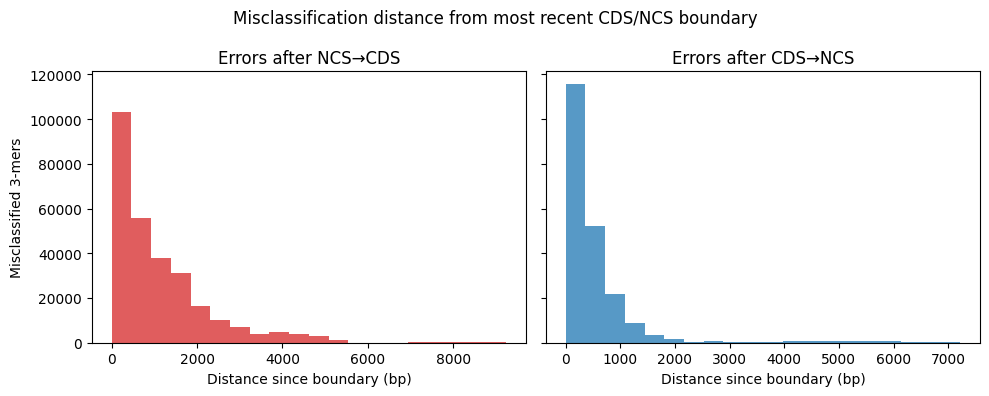

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

errors = predictions != y_test

# locate boundary indices/directions inside the contiguous test segment
boundary_info = {}
for idx in range(1, len(y_test)):
    if y_test[idx] != y_test[idx - 1]:
        direction = "NCS→CDS" if y_test[idx - 1] == 0 else "CDS→NCS"
        boundary_info[idx] = direction

dist_since_boundary = np.full(len(y_test), np.inf)
last_boundary_type = np.array([None] * len(y_test), dtype=object)

running = np.inf
current_type = None
for idx in range(len(y_test)):
    if idx in boundary_info:
        running = 0
        current_type = boundary_info[idx]
    elif running != np.inf:
        running += 1
    dist_since_boundary[idx] = running
    last_boundary_type[idx] = current_type

valid = np.isfinite(dist_since_boundary)
error_distances = dist_since_boundary[errors & valid]

print(f"Mean distance since boundary (errors): {error_distances.mean():.2f} bp")
print(f"Mean distance since boundary (all positions with boundary history): {dist_since_boundary[valid].mean():.2f} bp")

bins = np.array([0, 1, 2, 3, 5, 10, 20, np.inf])
bin_ids = np.digitize(dist_since_boundary, bins, right=False)
bucket_rows = []
for i in range(1, len(bins)):
    mask = (bin_ids == i) & valid
    if mask.any():
        bucket_rows.append(
            {
                "distance_range": f"[{bins[i-1]}, {bins[i]})",
                "positions": int(mask.sum()),
                "error_rate": errors[mask].mean(),
            }
        )
display(pd.DataFrame(bucket_rows))

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for ax, direction in zip(axes, ["NCS→CDS", "CDS→NCS"]):
    type_mask = (last_boundary_type == direction) & valid
    ax.hist(
        dist_since_boundary[type_mask & errors],
        bins=20,
        color="#d62728" if direction == "NCS→CDS" else "#1f77b4",
        alpha=0.75,
    )
    ax.set_title(f"Errors after {direction}")
    ax.set_xlabel("Distance since boundary (bp)")
axes[0].set_ylabel("Misclassified 3-mers")
fig.suptitle("Misclassification distance from most recent CDS/NCS boundary")
plt.tight_layout()
plt.show()


# Comparisons to other genomes

## Schizosaccharomyces Pombe

Schizosaccharomyces Pombe is similar to Saccharomyces Cerevisiae, as they both belong to the same phylum (Ascomycota). Saccharomyces C. is a budding yeast, while Schizosaccharomyces P. is a fission yeast.

### Parse Data

In [9]:
fission_df = pd.read_csv("../training_data/fission_yeast_3-mers.csv")
fission_df.head()

,3mer,coding
0,GAT,1
1,ATC,1
2,TCA,1
3,CAC,1
4,ACG,1


In [10]:
#we have some missing data!
missing_kmers = fission_df['3mer'].value_counts().tail(14).sum()
print(f"Dropping {missing_kmers} observations with unknown nucleotides ({missing_kmers / len(fission_df) * 100:.4f}% of data)")
invalid = [kmer for kmer in fission_df['3mer'].unique() if 'N' in kmer]
fission_df = fission_df[~fission_df['3mer'].isin(invalid)]

#verify results
print(f'New unique kmers: {len(fission_df["3mer"].unique())}')

Dropping 414 observations with unknown nucleotides (0.0033% of data)
New unique kmers: 64


In [11]:
#format into X and y
fission_X = np.array([mer_to_idx[mer] for mer in fission_df['3mer']]).reshape(-1, 1)

# Get true states
fission_y = fission_df['coding'].values

print(f"Total 3-mers: {len(X)}")
print(f"Class distribution: Non-coding={np.sum(y==0)}, Coding={np.sum(y==1)}")

Total 3-mers: 12157103
Class distribution: Non-coding=3403065, Coding=8754038


### Model Performance

In [12]:
#generate predictions from existing model, compare to true labels
fission_logprob, fission_predictions = model.decode(fission_X, algorithm="viterbi")

fission_accuracy = accuracy_score(fission_y, fission_predictions)

print(f"Accuracy on Schizosaccharomyces Pombe: {fission_accuracy*100:.2f}%")
print(f"Accuracy on test data (previously calculated): {accuracy*100:.2f}%")

Accuracy on Schizosaccharomyces Pombe: 81.84%
Accuracy on test data (previously calculated): 79.74%
